In [1]:
import pandas as pd

data = pd.read_csv("../processed_data/data.csv", index_col=0)

# Assuming df is your DataFrame
correlation_matrix = data.corr()

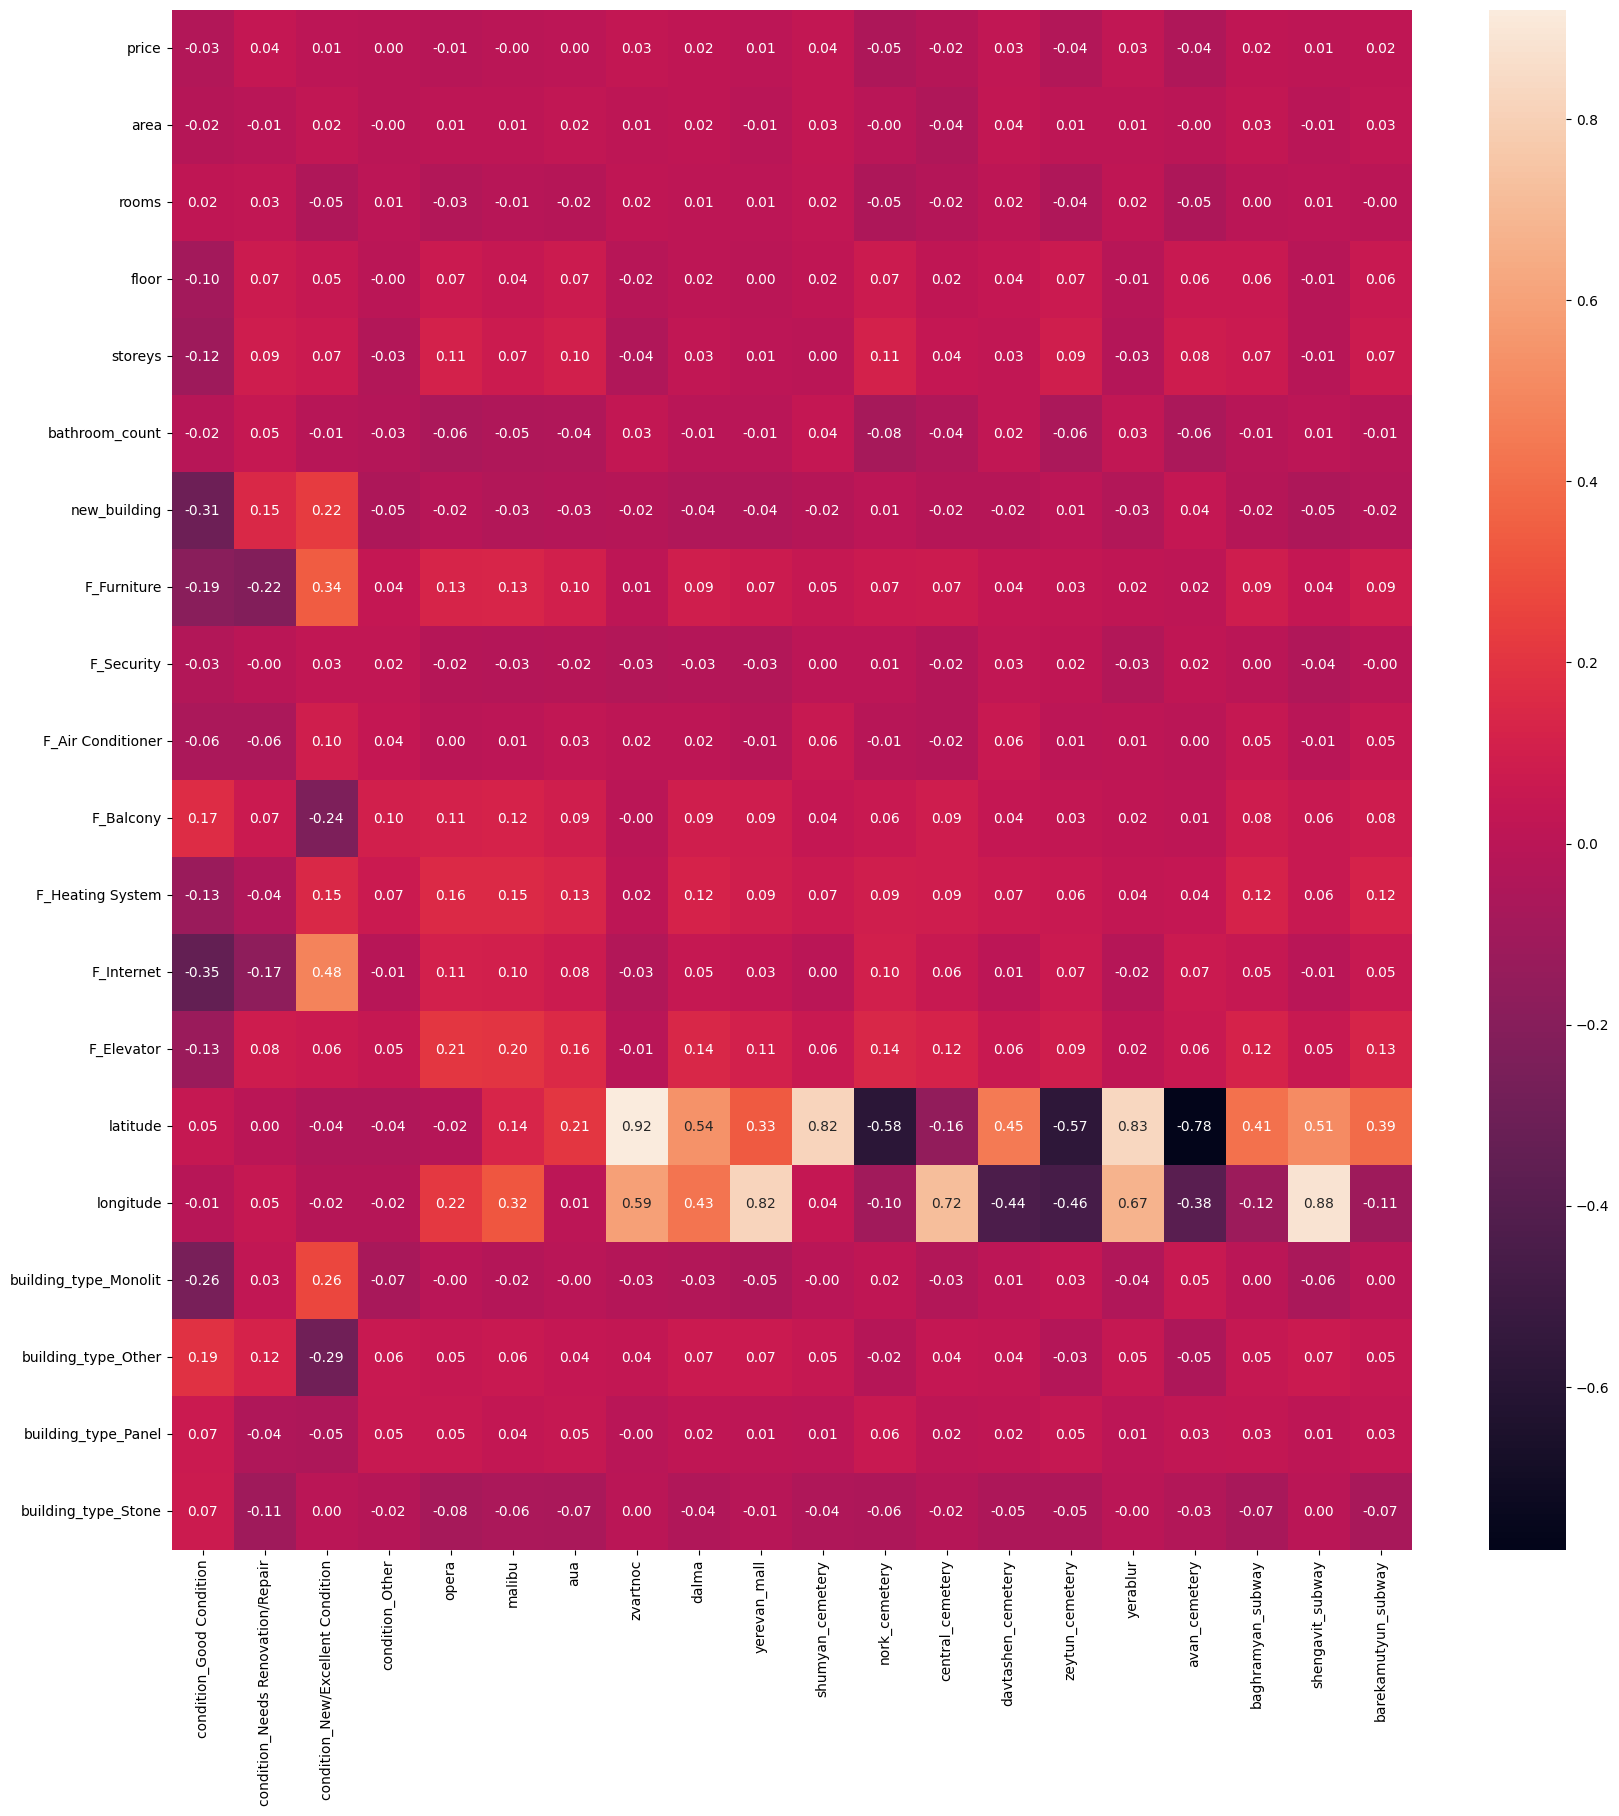

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix.iloc[:20,20:40], annot=True, fmt=".2f")
plt.show()


In [10]:
import torch


L1Loss()

In [14]:
c = torch.nn.L1Loss()
c(torch.tensor([1,2,3], dtype=torch.float64), torch.tensor([4,5,6], dtype=torch.float64))

tensor(3., dtype=torch.float64)

In [16]:
abs(1 - 4) + abs(2-5) + abs(3-6)/3

7.0

In [9]:
torch.__version__

'2.1.0'

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2476 entries, 0 to 2801
Data columns (total 69 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   source                             2476 non-null   object 
 1   id                                 2476 non-null   object 
 2   price                              2476 non-null   float64
 3   area                               2476 non-null   float64
 4   rooms                              2476 non-null   float64
 5   floor                              2476 non-null   float64
 6   storeys                            2476 non-null   float64
 7   bathroom_count                     2476 non-null   float64
 8   new_building                       2476 non-null   int64  
 9   F_Furniture                        2476 non-null   int64  
 10  F_Security                         2476 non-null   int64  
 11  F_Air Conditioner                  2476 non-null   int64